In [1]:
# Cell 1 - imports and environment
import os
import zipfile
import requests
from pathlib import Path
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# Cell 2 - download & extract ESC-50 (if not present)
DATA_DIR = Path("data/esc50")
ZIP_PATH = DATA_DIR / "esc50-master.zip"
ESC50_URL = "https://github.com/karolpiczak/ESC-50/archive/master.zip"

DATA_DIR.mkdir(parents=True, exist_ok=True)

if not ZIP_PATH.exists():
    r = requests.get(ESC50_URL, stream=True, timeout=30)
    r.raise_for_status()
    with open(ZIP_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

# Extract
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(DATA_DIR)
print("Extracted to", DATA_DIR)
meta_path = DATA_DIR / "ESC-50-master" / "meta" / "esc50.csv"
print("Meta CSV:", meta_path)
meta = pd.read_csv(meta_path)
meta.head()


Extracted to data/esc50
Meta CSV: data/esc50/ESC-50-master/meta/esc50.csv


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Total clips in CSV: 2000
Unique classes: 50
Example file: data/esc50/ESC-50-master/audio/1-100032-A-0.wav


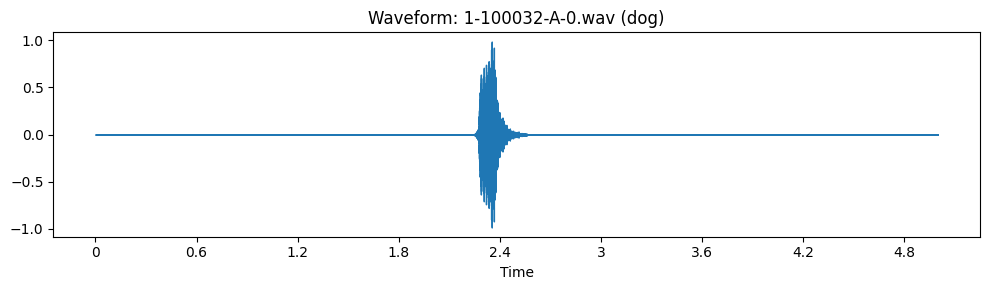

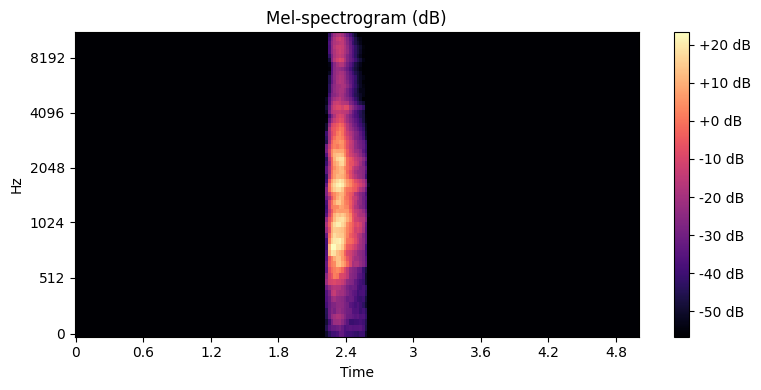

In [3]:
# Cell 3 - inspect dataset and plot an example
print("Total clips in CSV:", len(meta))
print("Unique classes:", meta['category'].nunique())

# pick one example and plot waveform + mel-spectrogram
example = meta.iloc[0]
example_file = DATA_DIR / "ESC-50-master" / "audio" / example['filename']
print("Example file:", example_file)

y, sr = librosa.load(example_file, sr=22050, duration=5.0)
plt.figure(figsize=(10,3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform: {example['filename']} ({example['category']})")
plt.tight_layout()
plt.show()

# mel-spectrogram
melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
logmelspec = librosa.power_to_db(melspec)
plt.figure(figsize=(8,4))
librosa.display.specshow(logmelspec, sr=sr, x_axis='time', y_axis='mel')
plt.title("Mel-spectrogram (dB)")
plt.colorbar(format="%+2.0f dB")
plt.tight_layout()
plt.show()


“The mel scale is a perceptual frequency scale: it’s roughly linear at low frequencies and roughly logarithmic at high frequencies. It models how humans (and many animals) perceive pitch, so mel spectrograms emphasize low-frequency detail while compressing high-frequency information.”

In [4]:
# Cell 4 - dataset class
class ESC50Dataset(Dataset):
    def __init__(self, metadata_df, base_dir, sr=22050, n_mels=64, duration=5.0, n_fft=2048, hop_length=512):
        """
        metadata_df: pandas DataFrame (must have 'filename' and 'target' columns)
        base_dir: Path to DATA_DIR where ESC-50-master sits
        """
        self.df = metadata_df.reset_index(drop=True)
        self.base_audio_dir = Path(base_dir) / "ESC-50-master" / "audio"
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.samples = int(sr * duration)
        self.n_fft = n_fft
        self.hop_length = hop_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = self.base_audio_dir / row['filename']
        y, sr = librosa.load(str(file_path), sr=self.sr, duration=self.duration)
        # pad if short
        if y.shape[0] < self.samples:
            y = np.pad(y, (0, self.samples - y.shape[0]), mode='constant')
        else:
            y = y[:self.samples]
        # mel spectrogram
        melspec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels,
                                                 n_fft=self.n_fft, hop_length=self.hop_length)
        logmelspec = librosa.power_to_db(melspec, ref=np.max).astype(np.float32)
        # normalize each example (optional)
        logmelspec = (logmelspec - logmelspec.mean()) / (logmelspec.std() + 1e-9)
        X = torch.from_numpy(logmelspec).unsqueeze(0)  # shape: (1, n_mels, time)
        y_label = int(row['target'])
        return X, y_label


In [17]:
# Cell 5 - Dataset creation and loaders
SUBSET_SIZE = 2000   # how many clips to use (total dataset = 2000 clips)
BATCH_SIZE = 32      # how many clips per training step

# take a stratified sample so each of the 50 classes is represented fairly
subset_df = meta.groupby('target', group_keys=False).apply(
    lambda g: g.sample(n=max(1, int(SUBSET_SIZE/50)), random_state=SEED)
).reset_index(drop=True)

dataset_full = ESC50Dataset(subset_df, base_dir=DATA_DIR)

# split into 80% train, 20% validation
train_size = int(0.8 * len(dataset_full))
val_size = len(dataset_full) - train_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size])

# PyTorch DataLoaders handle batching & shuffling
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


/tmp/ipython-input-2652812022.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset_df = meta.groupby('target', group_keys=False).apply(


In [18]:
print("Train set size:", len(train_ds))
print("Val set size:", len(val_ds))
print("Number of classes:", subset_df['target'].nunique())


Train set size: 1600
Val set size: 400
Number of classes: 50


In [19]:
# Cell 6 - Model definition
class AudioCNN(nn.Module):
    def __init__(self, n_classes=50):
        super().__init__()
        # Three convolutional “feature extractor” blocks
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Global pooling ensures output size doesn’t depend on input length
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)         # shrink to (batch, 64, 1, 1)
        x = x.view(x.size(0), -1)  # flatten to (batch, 64)
        return self.fc(x)

model = AudioCNN(n_classes=50).to(device)

Defines a CNN to classify mel spectrograms.
Convs + ReLU + pooling gradually compress the spectrogram into features.
Adaptive pooling makes the output fixed-size regardless of input length.
Final linear layer maps features to 50 sound classes.

In [20]:
# Print the architecture
print(model)

# Sanity check with a dummy input: one batch of size 1, 64 mel bands, 431 time frames
dummy = torch.zeros(1, 1, 64, 431).to(device)
out = model(dummy)
print("Output shape:", out.shape)


AudioCNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=50, bias=True)
)
Output 

In [21]:
# Cell 7 - training
import time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in tqdm(loader, desc="Train", leave=False):
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_true, all_pred = [], []
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Val", leave=False):
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item() * X.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            all_true.extend(y.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
    return running_loss / total, correct / total, all_true, all_pred

EPOCHS = 50
best_val_acc = 0.0
save_path = "esc50_cnn_best.pth"

for epoch in range(EPOCHS):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, y_true, y_pred = validate(model, val_loader, criterion)
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS} | train_loss={train_loss:.4f} train_acc={train_acc:.3f} | val_loss={val_loss:.4f} val_acc={val_acc:.3f} | time={(time.time()-t0):.1f}s")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch}, save_path)
        print("Saved best model.")


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 | train_loss=3.7642 train_acc=0.068 | val_loss=3.6330 val_acc=0.120 | time=26.7s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 | train_loss=3.4481 train_acc=0.151 | val_loss=3.3551 val_acc=0.152 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 | train_loss=3.1988 train_acc=0.219 | val_loss=3.1711 val_acc=0.242 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 | train_loss=2.9979 train_acc=0.287 | val_loss=3.0232 val_acc=0.282 | time=26.5s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 | train_loss=2.8202 train_acc=0.309 | val_loss=2.8840 val_acc=0.300 | time=26.9s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 | train_loss=2.6794 train_acc=0.367 | val_loss=2.7650 val_acc=0.338 | time=26.7s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 | train_loss=2.5854 train_acc=0.394 | val_loss=2.7003 val_acc=0.318 | time=26.5s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 | train_loss=2.5314 train_acc=0.403 | val_loss=2.6545 val_acc=0.315 | time=26.5s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 | train_loss=2.4610 train_acc=0.415 | val_loss=2.6016 val_acc=0.335 | time=25.9s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 | train_loss=2.3937 train_acc=0.439 | val_loss=2.5309 val_acc=0.375 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 | train_loss=2.3291 train_acc=0.453 | val_loss=2.4958 val_acc=0.383 | time=26.0s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 | train_loss=2.2881 train_acc=0.459 | val_loss=2.4823 val_acc=0.383 | time=26.3s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50 | train_loss=2.2636 train_acc=0.476 | val_loss=2.4260 val_acc=0.398 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50 | train_loss=2.2279 train_acc=0.475 | val_loss=2.3988 val_acc=0.403 | time=26.6s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50 | train_loss=2.2024 train_acc=0.493 | val_loss=2.3841 val_acc=0.410 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50 | train_loss=2.1774 train_acc=0.505 | val_loss=2.3746 val_acc=0.410 | time=26.4s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 17/50 | train_loss=2.1571 train_acc=0.512 | val_loss=2.3681 val_acc=0.412 | time=31.1s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50 | train_loss=2.1382 train_acc=0.517 | val_loss=2.3516 val_acc=0.412 | time=26.3s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50 | train_loss=2.1272 train_acc=0.511 | val_loss=2.3319 val_acc=0.420 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50 | train_loss=2.1305 train_acc=0.514 | val_loss=2.3237 val_acc=0.417 | time=26.4s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50 | train_loss=2.0980 train_acc=0.515 | val_loss=2.3179 val_acc=0.415 | time=26.7s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50 | train_loss=2.0947 train_acc=0.532 | val_loss=2.3065 val_acc=0.417 | time=26.9s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50 | train_loss=2.0880 train_acc=0.517 | val_loss=2.2992 val_acc=0.415 | time=26.7s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50 | train_loss=2.0789 train_acc=0.527 | val_loss=2.2881 val_acc=0.415 | time=26.6s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 25/50 | train_loss=2.0776 train_acc=0.520 | val_loss=2.2921 val_acc=0.422 | time=26.3s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50 | train_loss=2.0677 train_acc=0.529 | val_loss=2.2797 val_acc=0.425 | time=26.6s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50 | train_loss=2.0687 train_acc=0.519 | val_loss=2.2911 val_acc=0.422 | time=26.4s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50 | train_loss=2.0674 train_acc=0.536 | val_loss=2.2753 val_acc=0.427 | time=26.1s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50 | train_loss=2.0535 train_acc=0.532 | val_loss=2.2826 val_acc=0.420 | time=26.5s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50 | train_loss=2.0445 train_acc=0.543 | val_loss=2.2734 val_acc=0.427 | time=26.2s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50 | train_loss=2.0450 train_acc=0.542 | val_loss=2.2792 val_acc=0.425 | time=26.5s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 32/50 | train_loss=2.0423 train_acc=0.534 | val_loss=2.2763 val_acc=0.422 | time=26.8s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50 | train_loss=2.0432 train_acc=0.542 | val_loss=2.2711 val_acc=0.425 | time=26.7s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50 | train_loss=2.0398 train_acc=0.545 | val_loss=2.2720 val_acc=0.427 | time=26.6s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50 | train_loss=2.0411 train_acc=0.530 | val_loss=2.2594 val_acc=0.427 | time=27.0s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50 | train_loss=2.0420 train_acc=0.547 | val_loss=2.2604 val_acc=0.420 | time=26.5s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50 | train_loss=2.0333 train_acc=0.545 | val_loss=2.2646 val_acc=0.432 | time=26.4s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50 | train_loss=2.0333 train_acc=0.546 | val_loss=2.2663 val_acc=0.427 | time=26.9s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50 | train_loss=2.0416 train_acc=0.536 | val_loss=2.2573 val_acc=0.430 | time=26.6s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 40/50 | train_loss=2.0436 train_acc=0.547 | val_loss=2.2606 val_acc=0.422 | time=26.9s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50 | train_loss=2.0428 train_acc=0.539 | val_loss=2.2635 val_acc=0.430 | time=26.6s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50 | train_loss=2.0328 train_acc=0.546 | val_loss=2.2659 val_acc=0.435 | time=28.1s
Saved best model.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50 | train_loss=2.0212 train_acc=0.544 | val_loss=2.2704 val_acc=0.432 | time=26.8s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50 | train_loss=2.0336 train_acc=0.550 | val_loss=2.2660 val_acc=0.427 | time=27.5s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50 | train_loss=2.0260 train_acc=0.540 | val_loss=2.2612 val_acc=0.422 | time=26.7s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50 | train_loss=2.0400 train_acc=0.529 | val_loss=2.2571 val_acc=0.427 | time=27.7s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50 | train_loss=2.0335 train_acc=0.541 | val_loss=2.2612 val_acc=0.422 | time=27.6s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 48/50 | train_loss=2.0375 train_acc=0.533 | val_loss=2.2595 val_acc=0.425 | time=27.9s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50 | train_loss=2.0406 train_acc=0.542 | val_loss=2.2535 val_acc=0.427 | time=26.8s


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50 | train_loss=2.0300 train_acc=0.543 | val_loss=2.2598 val_acc=0.427 | time=26.4s


Trains the model for EPOCHS (6 for a quick run, then try 50).
Training phase: feeds batches of spectrograms, updates weights with backprop.
Validation phase: evaluates performance on held-out data.
Tracks accuracy and loss.
Uses a learning-rate scheduler to reduce LR every few epochs.

Val:   0%|          | 0/13 [00:00<?, ?it/s]

Validation accuracy: 0.4275
              precision    recall  f1-score   support

           0       0.31      0.45      0.37        11
           1       0.44      0.67      0.53        12
           2       0.75      0.50      0.60         6
           3       1.00      0.12      0.22        16
           4       0.50      0.43      0.46         7
           5       1.00      0.40      0.57        10
           6       0.17      0.11      0.13         9
           7       0.40      0.29      0.33         7
           8       0.38      0.60      0.46         5
           9       0.50      0.20      0.29        10
          10       0.50      0.56      0.53         9
          11       0.20      0.60      0.30         5
          12       0.71      0.83      0.77        12
          13       0.50      0.60      0.55         5
          14       0.50      0.60      0.55         5
          15       0.33      0.14      0.20         7
          16       0.43      0.43      0.43         7

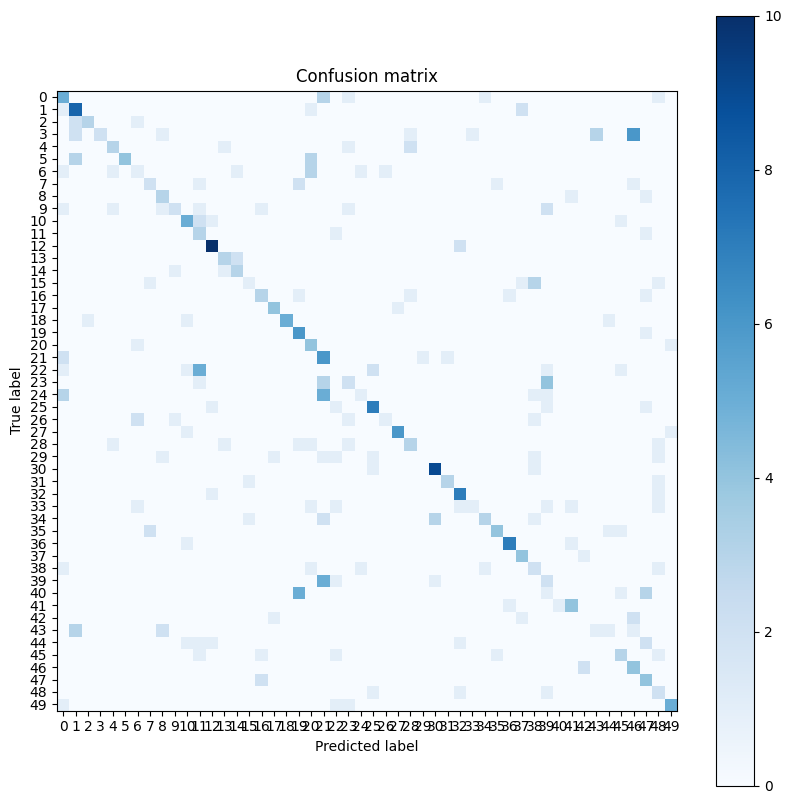

In [22]:
val_loss, val_acc, y_true, y_pred = validate(model, val_loader, criterion)
print("Validation accuracy:", val_acc)
print(classification_report(y_true, y_pred))

# Confusion matrix (for readability, show only top-K classes if 50 is too big)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, include_values=False, cmap='Blues')
plt.title("Confusion matrix")
plt.show()


In [16]:
# Cell 9 - uncertainty scoring (entropy)
import torch.nn.functional as F

def entropy_scores(model, loader, top_k=20):
    model.eval()
    scores = []
    paths = []
    with torch.no_grad():
        for X, _ in loader:
            X = X.to(device)
            logits = model(X)
            probs = F.softmax(logits, dim=1)
            ent = -(probs * probs.log()).sum(dim=1)  # entropy per sample
            scores.extend(ent.cpu().numpy().tolist())
    return np.array(scores)

# Example: compute entropy on validation set
entropies = entropy_scores(model, val_loader)
print("Entropy stats:", np.min(entropies), np.mean(entropies), np.max(entropies))


Entropy stats: 2.3049874305725098 3.6186769104003904 3.8765830993652344
